In [1]:
import pyreadr
import numpy as np
import pandas as pd
from time import time
from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict,RepeatedStratifiedKFold, StratifiedKFold, RepeatedKFold, KFold, validation_curve, learning_curve, train_test_split,RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, precision_score, precision_recall_curve, roc_auc_score, matthews_corrcoef, precision_score, make_scorer, SCORERS, classification_report
from sklearn.utils import class_weight, compute_class_weight, compute_sample_weight,shuffle
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Ridge
from functools import partial
import matplotlib.pyplot as plt

# <u>Preprocess Data </u>

### Import Transcript Stability Data

In [21]:
transcript_stability = pyreadr.read_r('transcript_stability_non_norm.RData')
#transcript_stability = pyreadr.read_r('~/Desktop/test.RData')
transcript_stability = transcript_stability["transcript_stability"]
transcript_stability = pd.DataFrame(transcript_stability)

### Remove transcript version from id's (*.number)

In [22]:
transcript_stability["transcript_id"] = transcript_stability["transcript_id"].str.split(".").str[0]

### Remove Housekeeping transcripts

In [23]:
h = pd.read_csv("Housekeeping_TranscriptsHuman.csv", delimiter=";")
house_genes = h["Ensembl"].values
transcript_stability = transcript_stability[~transcript_stability["transcript_id"].isin(house_genes)]

In [24]:
### Import Transcript Stability Data

#transcript_stability = pyreadr.read_r('transcript_stability_non_norm_med_remove_TSS.RData')
#transcript_stability = transcript_stability["transcript_stability"]
#transcript_stability = pd.DataFrame(transcript_stability)

### Remove transcript version from id's (*.number)

transcript_stability["transcript_id"] = transcript_stability["transcript_id"].str.split(".").str[0]

### Remove Housekeeping transcripts

h = pd.read_csv("Housekeeping_TranscriptsHuman.csv", delimiter=";")
house_genes = h["Ensembl"].values
transcript_stability = transcript_stability[~transcript_stability["transcript_id"].isin(house_genes)]

### Define stable/unstable transcripts

In [25]:
transcript_stability["stability"] = "NO"
transcript_stability_gcsi_ccle = transcript_stability.copy() 
transcript_stability_gdsc_ccle = transcript_stability.copy()
transcript_stability_gcsi_gdsc = transcript_stability.copy()

transcript_stability_gcsi_ccle.loc[transcript_stability_gcsi_ccle["gcsi_ccle"] > 0.8, "stability"] = "YES"
transcript_stability_gcsi_ccle.loc[transcript_stability_gcsi_ccle["gcsi_ccle"] < 0.8, "stability"] = "NO"

transcript_stability_gcsi_gdsc.loc[transcript_stability_gcsi_gdsc["gcsi_gdsc"] > 0.8, "stability"] = "YES"
transcript_stability_gcsi_gdsc.loc[transcript_stability_gcsi_gdsc["gcsi_gdsc"] < 0.8, "stability"] = "NO"

transcript_stability_gdsc_ccle.loc[transcript_stability_gdsc_ccle["gdsc_ccle"] > 0.8, "stability"] = "YES"
transcript_stability_gdsc_ccle.loc[transcript_stability_gdsc_ccle["gdsc_ccle"] < 0.8, "stability"] = "NO"

### Isolate MOST stable/unstable transcripts

#### gCSI/CCLE

In [26]:
stable = transcript_stability_gcsi_ccle.sort_values('gcsi_ccle', ascending=False)
stable = stable.iloc[0:3014]

unstable = transcript_stability_gcsi_ccle.sort_values('gcsi_ccle', ascending=True)
unstable = unstable.iloc[0:3014]

transcript_stability_gcsi_ccle = stable.append(unstable)

#### gCSI/GDSC

In [27]:
stable = transcript_stability_gcsi_gdsc.sort_values('gcsi_gdsc', ascending=False)
stable = stable.iloc[0:3014]

unstable = transcript_stability_gcsi_gdsc.sort_values('gcsi_gdsc', ascending=True)
unstable = unstable.iloc[0:3014]

transcript_stability_gcsi_gdsc = stable.append(unstable)

#### GDSC/CCLE

In [28]:
stable = transcript_stability_gdsc_ccle.sort_values('gdsc_ccle', ascending=False)
stable = stable.iloc[0:3014]

unstable = transcript_stability_gdsc_ccle.sort_values('gdsc_ccle', ascending=True)
unstable = unstable[0:3014]

transcript_stability_gdsc_ccle = stable.append(unstable)

In [29]:
transcript_stability_gdsc_ccle

,transcript_id,gcsi_mad,ccle_mad,gdsc_mad,gcsi_median,gdsc_median,ccle_median,gcsi_ccle,gcsi_gdsc,gdsc_ccle,length,n_exon,gc,stability
60607,ENST00000378616,626.398500,572.283600,1249.831800,458.500000,845.000000,395.000000,0.920200,0.913602,0.965338,5174.0,3.0,41.631233,YES
50295,ENST00000355797,354.764465,409.538260,1077.094582,278.747411,886.433199,339.989603,0.900239,0.915545,0.959075,5661.0,4.0,50.733086,YES
20041,ENST00000369838,1696.835700,1675.338000,6103.864200,1373.500000,4360.000000,1229.000000,0.927240,0.910329,0.958070,4603.0,4.0,38.865957,YES
43415,ENST00000327355,345.390306,289.295815,1137.008356,241.746203,787.715837,210.220346,0.921190,0.939861,0.957338,2604.0,3.0,53.840246,YES
38380,ENST00000381020,175.776181,339.480649,1186.580078,118.559410,800.337298,231.112914,0.922642,0.925671,0.955438,3448.0,3.0,59.628770,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53326,ENST00000340790,0.000059,0.000000,0.000000,0.000040,0.000000,0.000000,-0.092308,0.091693,0.020511,2260.0,6.0,61.548673,NO
23097,ENST00000621093,109.357374,101.499068,214.924868,76.373396,543.884246,68.460184,0.234413,0.160317,0.020519,348.0,4.0,54.022989,NO
26171,ENST00000527194,271.182101,195.119547,8.831772,182.910365,5.956948,288.943274,0.202242,0.342965,0.020538,806.0,5.0,59.429280,NO
17743,ENST00000523705,0.000000,2.917941,0.000000,0.000000,0.000000,1.968124,0.111750,0.104437,0.020573,576.0,6.0,49.131944,NO


### Extract features +  stability from df

In [30]:
transcript_stability_gcsi_ccle = transcript_stability_gcsi_ccle.loc[:,['gdsc_median','n_exon','gc','length','stability']]
transcript_stability_gcsi_gdsc = transcript_stability_gcsi_gdsc.loc[:,['ccle_median','n_exon','gc','length','stability']]
transcript_stability_gdsc_ccle = transcript_stability_gdsc_ccle.loc[:,['gcsi_median','n_exon','gc','length','stability']]

# <u>Hyperparameter Optimization (RandomizedSearchCV, GridSearchCV) </u>

#### Define parameters

In [75]:
scores = ['precision', 'recall']

param_grid = {
'n_estimators': [100, 200, 300, 400], 
'max_depth': [2, 4, 6, 8]
}

In [77]:
sk_fold = StratifiedKFold(n_splits=10, shuffle=True)

rf = RandomForestClassifier()
ada_boost = AdaBoostClassifier()

### RandomizedSearchCV

- Does NOT test all combinations of hyperparameters, but rather random combinations (lower compute time than GridSearchCV). Typically used FIRST to reduce the parameter space (identify some parameters not to tune in GridSearchCV, which will reduce parameter space before running GridSearchCV next). When you launch GridSearchCV on this reduced parameter space, there will be a reduced computation time of GridSearchCV for searching for the optimal features)

In [79]:
feat = ['median_exp','length','n_exon']
for i in feat:
    if (i == 'median_exp'):
        x1 = transcript_stability_gcsi_ccle[["gdsc_median"]].values
        x2 = transcript_stability_gcsi_gdsc[["ccle_median"]].values
        x3 = transcript_stability_gdsc_ccle[["gcsi_median"]].values
    else:
        x1 = transcript_stability_gcsi_ccle[[i]].values
        x2 = transcript_stability_gcsi_gdsc[[i]].values
        x3 = transcript_stability_gdsc_ccle[[i]].values
    
    y1 = transcript_stability_gcsi_ccle.stability.replace(to_replace=['NO', 'YES'], value=[0, 1])
    y2 = transcript_stability_gcsi_gdsc.stability.replace(to_replace=['NO', 'YES'], value=[0, 1])
    y3 = transcript_stability_gdsc_ccle.stability.replace(to_replace=['NO', 'YES'], value=[0, 1])
    
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        rs1 = RandomizedSearchCV(
        rf, param_grid, cv=sk_fold ,scoring='%s_macro' % score)
        rs1.fit(x1, y1)
    
        rs2 = RandomizedSearchCV(
        rf, param_grid, cv=sk_fold ,scoring='%s_macro' % score)
        rs2.fit(x2, y2)
    
        rs3 = RandomizedSearchCV(
        rf, param_grid, cv=sk_fold ,scoring='%s_macro' % score)
        rs3.fit(x3, y3)
    
    

        print()
        print(i + ":" + "gcsi/ccle")
        print("\n The best score:\n",
          rs1.best_score_)
        print("\n The best parameter:\n",
          rs1.best_params_)
        print()
        print(i + ":" + "gcsi/gdsc")
        print("\n The best score:\n",
          rs2.best_score_)
        print("\n The best parameter:\n",
          rs2.best_params_)
        print()
        print(i + ":" + "gdsc/ccle")
        print("\n The best score:\n",
          rs3.best_score_)
        print("\n The best parameter:\n",
          rs3.best_params_)

# Tuning hyper-parameters for precision


median_exp:gcsi/ccle

 The best score across ALL searched params:
 0.7766614736626185

 The best parameters across ALL searched params:
 {'n_estimators': 400, 'max_depth': 4}

median_exp:gcsi/gdsc

 The best score across ALL searched params:
 0.7161772873713154

 The best parameters across ALL searched params:
 {'n_estimators': 100, 'max_depth': 2}

median_exp:gdsc/ccle

 The best score across ALL searched params:
 0.8017102835386659

 The best parameters across ALL searched params:
 {'n_estimators': 400, 'max_depth': 4}
# Tuning hyper-parameters for recall


median_exp:gcsi/ccle

 The best score across ALL searched params:
 0.7749300814851019

 The best parameters across ALL searched params:
 {'n_estimators': 400, 'max_depth': 4}

median_exp:gcsi/gdsc

 The best score across ALL searched params:
 0.7059321865761958

 The best parameters across ALL searched params:
 {'n_estimators': 300, 'max_depth': 4}

median_exp:gdsc/ccle

 The best score ac

### GridSearchCV

In [65]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        rf, param_grid, cv=sk_fold, scoring='%s_macro' % score
    )
    clf.fit(x1, y1_t)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'max_depth': 4, 'n_estimators': 200}

Grid scores on development set:

0.772 (+/-0.029) for {'max_depth': 2, 'n_estimators': 100}
0.772 (+/-0.028) for {'max_depth': 2, 'n_estimators': 200}
0.772 (+/-0.029) for {'max_depth': 2, 'n_estimators': 300}
0.777 (+/-0.027) for {'max_depth': 4, 'n_estimators': 100}
0.778 (+/-0.029) for {'max_depth': 4, 'n_estimators': 200}
0.777 (+/-0.030) for {'max_depth': 4, 'n_estimators': 300}
0.775 (+/-0.027) for {'max_depth': 6, 'n_estimators': 100}
0.774 (+/-0.027) for {'max_depth': 6, 'n_estimators': 200}
0.776 (+/-0.029) for {'max_depth': 6, 'n_estimators': 300}

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'max_depth': 4, 'n_estimators': 200}

Grid scores on development set:

0.771 (+/-0.027) for {'max_depth': 2, 'n_estimators': 100}
0.771 (+/-0.026) for {'max_depth': 2, 'n_estimators': 200}
0.771 (+/-0.024) for {'max_depth'

# <u>Build models with tuned hyperparameters </u>

In [35]:
rsk_fold = RepeatedStratifiedKFold(n_splits=10)
sk_fold = StratifiedKFold(n_splits=10)

## 1. Random Forest

In [41]:
rf = RandomForestClassifier(n_estimators=100, max_depth=8)

In [32]:
transcript_stability_gcsi_ccle_f = shuffle(transcript_stability_gcsi_ccle, random_state=10)
transcript_stability_gcsi_gdsc_f = shuffle(transcript_stability_gcsi_gdsc, random_state=10)
transcript_stability_gdsc_ccle_f = shuffle(transcript_stability_gdsc_ccle, random_state=10)

In [39]:
x1 = transcript_stability_gcsi_ccle_f[["gdsc_median"]].values
y1 = transcript_stability_gcsi_ccle_f["stability"].values.ravel()

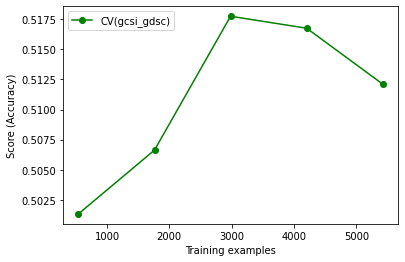

In [42]:
plt.figure()
plt.xlabel("Training examples")
plt.ylabel("Score (Accuracy)")

train_sizes, train_scores, valid_scores = learning_curve(rf, 
X=x1, y=y1, cv=sk_fold)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)
plt.grid()
plt.plot(train_sizes, valid_mean, 'o-', color="g", label='CV(gcsi_gdsc)')

plt.grid()
plt.legend(loc='upper left')
plt.savefig('figures/test.png', dpi=500)

#### Learning curves

In [85]:
feat = ['median_exp','length','n_exon']
for i in feat:
    if (i == 'median_exp'):
        x1 = transcript_stability_gcsi_ccle_f[["gdsc_median"]].values
        x2 = transcript_stability_gcsi_gdsc_f[["ccle_median"]].values
        x3 = transcript_stability_gdsc_ccle_f[["gcsi_median"]].values
    else:
        x1 = transcript_stability_gcsi_ccle_f[[i]].values
        x2 = transcript_stability_gcsi_gdsc_f[[i]].values
        x3 = transcript_stability_gdsc_ccle_f[[i]].values
    
    y1 = transcript_stability_gcsi_ccle_f["stability"].values.ravel()
    y2 = transcript_stability_gcsi_gdsc_f["stability"].values.ravel()
    y3 = transcript_stability_gdsc_ccle_f["stability"].values.ravel()
    
    plt.figure()
    plt.xlabel("Training examples")
    plt.ylabel("Score (Accuracy)")


    train_sizes, train_scores, valid_scores = learning_curve(rf, 
    X=x1, y=y1, cv=rsk_fold)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)
    plt.grid()
    plt.plot(train_sizes, valid_mean, 'o-', color="g", label='CV(gcsi_ccle):' + i)


    train_sizes, train_scores, valid_scores = learning_curve(rf, 
    X=x2, y=y2, cv=rsk_fold)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)
    plt.grid()
    plt.plot(train_sizes, valid_mean, 'o-', color="b", label='CV(gcsi_gdsc):' + i)


    train_sizes, train_scores, valid_scores = learning_curve(rf, 
    X=x3, y=y3, cv=rsk_fold)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)
    plt.grid()
    plt.plot(train_sizes, valid_mean, 'o-', color="r", label='CV(gdsc_ccle):' + i)


    plt.grid()
    plt.legend(loc='upper left')
    plt.savefig('figures/RF_tuned_removed/figure_tuned_' + i + '.png', dpi=500)
    plt.close()
    

## 2. ADA Boosting

In [38]:
ada_boost = AdaBoostClassifier(n_estimators=80)

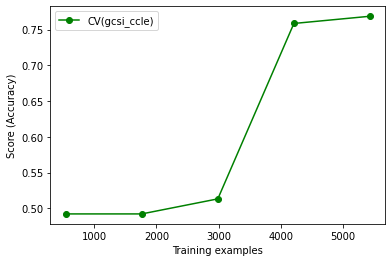

In [109]:
x1 = no_issues[["gdsc_median"]].values
y1 = no_issues["stability"].values.ravel()

plt.figure()
plt.xlabel("Training examples")
plt.ylabel("Score (Accuracy)")

train_sizes, train_scores, valid_scores = learning_curve(ada_boost, 
X=x1, y=y1, cv=rsk_fold)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)
plt.grid()
plt.plot(train_sizes, valid_mean, 'o-', color="g", label='CV(gcsi_ccle)')

plt.grid()
plt.legend(loc='upper left')
plt.savefig('figures/test.png', dpi=500)

#### Learning curves

In [39]:
feat = ['median_exp','length','n_exon']
for i in feat:
    if (i == 'median_exp'):
        x1 = transcript_stability_gcsi_ccle_f[["gdsc_median"]].values
        x2 = transcript_stability_gcsi_gdsc_f[["ccle_median"]].values
        x3 = transcript_stability_gdsc_ccle_f[["gcsi_median"]].values
    else:
        x1 = transcript_stability_gcsi_ccle_f[[i]].values
        x2 = transcript_stability_gcsi_gdsc_f[[i]].values
        x3 = transcript_stability_gdsc_ccle_f[[i]].values
    
    y1 = transcript_stability_gcsi_ccle_f["stability"].values.ravel()
    y2 = transcript_stability_gcsi_gdsc_f["stability"].values.ravel()
    y3 = transcript_stability_gdsc_ccle_f["stability"].values.ravel()
    
    plt.figure()
    plt.xlabel("Training examples")
    plt.ylabel("Score (Accuracy)")


    train_sizes, train_scores, valid_scores = learning_curve(ada_boost, 
    X=x1, y=y1, cv=rsk_fold)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)
    plt.grid()
    plt.plot(train_sizes, valid_mean, 'o-', color="g", label='CV(gcsi_ccle):'+ i)


    train_sizes, train_scores, valid_scores = learning_curve(ada_boost, 
    X=x2, y=y2, cv=rsk_fold)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)
    plt.grid()
    plt.plot(train_sizes, valid_mean, 'o-', color="b", label='CV(gcsi_gdsc):'+ i)


    train_sizes, train_scores, valid_scores = learning_curve(ada_boost, 
    X=x3, y=y3, cv=rsk_fold)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)
    plt.grid()
    plt.plot(train_sizes, valid_mean, 'o-', color="r", label='CV(gdsc_ccle):'+ i)


    plt.grid()
    plt.legend(loc='upper left')
    plt.savefig('figures/ADA/figure_' + i + '.png', dpi=500)
    plt.close()
    

## 3. Decision Tree

In [164]:
d_tree = DecisionTreeClassifier(max_depth=8)

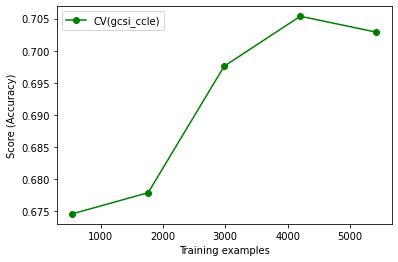

In [165]:
plt.figure()
plt.xlabel("Training examples")
plt.ylabel("Score (Accuracy)")

train_sizes, train_scores, valid_scores = learning_curve(d_tree, 
X=x1, y=y1, cv=sk_fold)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)
plt.grid()
plt.plot(train_sizes, valid_mean, 'o-', color="g", label='CV(gcsi_ccle)')

plt.grid()
plt.legend(loc='upper left')
plt.savefig('figures/test.png', dpi=500)